This is copied from [Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb#)

## Parent and Children relationship

* *parent variables* are variables that influence another variable.
* *Child variables* are variables that are affected by other variables

In [1]:
import pymc as pm

parameter = pm.Exponential("poisson_param", 1)
data_generator = pm.Poisson("data_generator", parameter)
data_plus_one = data_generator + 1

In [2]:
print("Childrend of `parameter`: ")
print(parameter.children)
print("\nParents of `data_generator`: ")
print(data_generator.parents)
print("\nChildren of `data_generator`: ")
print(data_generator.children)

Childrend of `parameter`: 
{<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x7fbb1c65a4d0>}

Parents of `data_generator`: 
{'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x7fba911c8410>}

Children of `data_generator`: 
{<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x7fbb1c65a710>}


In [3]:
print("parameter.value = ", parameter.value)
print("data_generator.value = ", data_generator.value)
print("data_plus_one.value = ", data_plus_one.value)

parameter.value =  1.5608880400459475
data_generator.value =  1
data_plus_one.value =  2


### PyMC Variables:

`stochastic` and `deterministc` variables:

* *stochastic variables* are variables that are not deterministic, i.e., even if you knew all the  values of the variables' parents, it would still be random.
* *determinsitc variables* are variables that are not random if the variables' parents were known.

#### Initializing Stochastic variables

Initializing a stochastic variable requires a `name` argument, plus additional parameters that are class specific. For example:

`some_variable = pm.DiscreteUniform("discrete_uni_var", 0, 4)`

Where 0, 4 are the `DeiscreteUniform`-specific lower and upper bound on the random variable. 

The `name` attribute is used to retrieve the posterior distribution later in the analysis.

<p>The `size` argument also solve the annoying case where you may have many variables $\beta_{i}, i = 1, ..., N$ you wish to model. Instead of creating arbitrary names and variables for each one, like:

&emsp; beta_1 = pm.Uniform("beta_1", 0, 1)

&emsp; beta_2 = pm.Uniform("beta_2", 0, 1)

&emsp; ...
    
we can instead wrap them into a single variable:
    betas = pm.Uniform("betas", 0, 1, size=N) </p>
    
#### Calling `random()`

<p> We can also call a stochastic variable's `random()` method, which (given the parent values) will generate a new, random value. Below we demonstrate this using the texting example from the previous chapter. </p>

In [4]:
lambda_1 = pm.Exponential("lambda_1", 1)
lambda_2 = pm.Exponential("lambda_2", 1)
tau = pm.DiscreteUniform("tau", lower=0, upper=10)

print("lamda_1.value = %.3f" % lambda_1.value)
print("lamda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)

lambda_1.random(), lambda_2.random(), tau.random()

print("After calling random() on the variables ...")
print("lamda_1.value = %.3f" % lambda_1.value)
print("lamda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)

lamda_1.value = 0.436
lamda_2.value = 0.386
tau.value = 1.000
After calling random() on the variables ...
lamda_1.value = 0.677
lamda_2.value = 0.600
tau.value = 6.000


The call to `random` stores a new value into the variable's `value` attribute.

### Warning: *Don't update stochastic variables' values in-place*

The only way a stochastic variable's value should be updated is using statment of the following form:

&emsp; A.value = new_value

The following are in-place updates and should **never** be used:

&emsp; A.value += 3

&emsp; A.value[2,1] = 5

&emsp; A.value.attribute = new_attribute_value

#### Deterministic variables

In [5]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [6]:
import numpy as np
n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

lambda_

<pymc.PyMCObjects.Deterministic 'lambda_' at 0x7fba85ab3250>

### Including observations in the Model

At this point, it may not look like it, but we have fully specified priors

(0.0, 8.0)

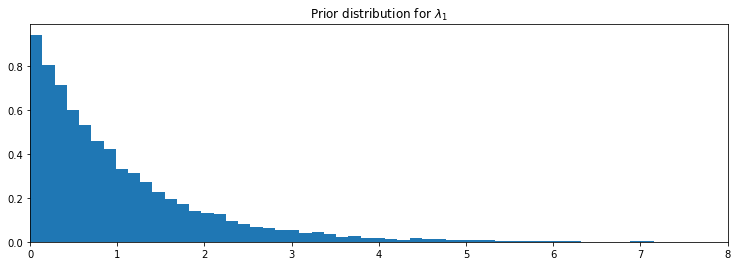

In [7]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

figsize(12.5, 4)

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins = 70, density = True, histtype="stepfilled")
plt.title("Prior distribution for $\lambda_1$")
plt.xlim(0, 8)

PyMC stochastic variables have a keyword argument `observed` which accept a boolean (`False` by default). The keyword `observed` has a very simple role: fix the variable's current value, i.e., make `value` immutable.

In [8]:
data = np.array([10, 5])
fixed_variable = pm.Poisson("fxd", 1, value = data, observed=True)
print("value: ", fixed_variable.value)
print("callling .random()")
fixed_variable.random()

print("value: ", fixed_variable.value)

value:  [10  5]
callling .random()
value:  [10  5]


To complete our text message example, we fix the PyMC variable `observation` to the observed dataset.

In [9]:
data = np.array([10, 25, 15, 20, 35])

obs = pm.Poisson("obs", lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


### Finally ...
We wrap all the created variables into a `pm.Model` class, With this `Model` class, we can analyze the variables as a single unit. This is an optional step, as the fitting algorithm can be sent an array of the variables rather than a `Model` class. 

In [10]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

### Same story; different ending.

Interestingly, we can create *new dataset* by retelling the story. E.g., if we reverse the above (analytical) steps, we can simulate a possible realization of the dataset. 

1. Specify when the user's behavior switches by sample from $DiscreteUniform(0, 80)$:

In [11]:
tau = pm.rdiscrete_uniform(0, 80)
print(tau)

23


2. Draw $\lambda_1$ and $\lambda_2$ from a $Exp(\alpha)$ distribution:

In [12]:
alpha = 1. /20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)

3.209934887075922 42.10742156050123


3. For days before $\tau$, represent the users' received SMS count by sampling from $Poi(\lambda_1)$, and sample from $Poi(\lambda_2)$ for days after $\tau$. For example:

In [13]:
data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]

4. Plot the artificial dataset:

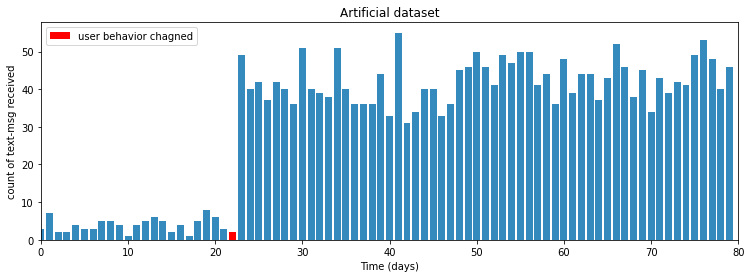

In [14]:
plt.bar(np.arange(80), data, color = "#348ABD")
plt.bar(tau-1, data[tau-1], color="r", label="user behavior chagned")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msg received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

The ability to generate artificial datasets is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference. We produce a few more datasets below:

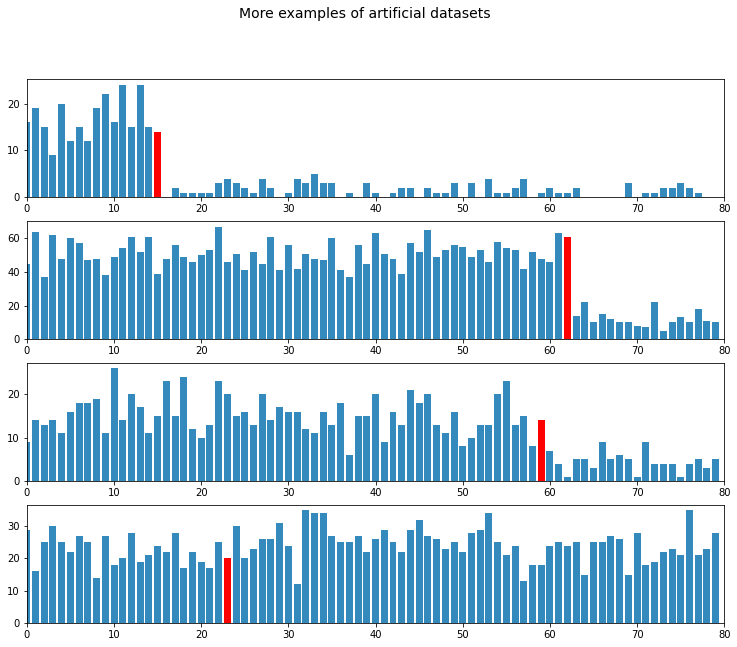

In [15]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(0, 80), data, color = "#348ABD")
    plt.bar(tau - 1, data[tau - 1], color = "r", label = "user behavior changed")
    plt.xlim(0, 80)
    
figsize(12.5, 10)
plt.suptitle("More examples of artificial datasets", fontsize=14)
for i in range(1, 5):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

### Example: Bayesian A/B Testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards.

#### A simple case

Suppose site A was shown to *N* people, and $n$ people purchased from the site. We need to infer the effectivenss of site A $P(A)$

Let's assume $P(A)$ is uniform over [0, 1]:

In [16]:
import pymc as pm

p = pm.Uniform('p', lower = 0, upper = 1)

For this example, consider $P(A) = 0.05$ and $N = 1500$. We will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we use a *Bernoulli* distribution: If $X \sim Ber(p)$, then, $X$ is 1 with probability $p$ and 0 with probability $1-p$. Of course, in practice, we do not know $P(A)$, but we will use it here to simulate the data.

In [17]:
p_true = 0.05
N = 1500

occurences = pm.rbernoulli(p_true, N)

print(occurences)
print(occurences.sum())

[False False False ... False False False]
75


In [18]:
print("what is the observed frequency in Group A? %.4f" % occurences.mean())
print("Does this equal the true frequency? %s" % (occurences.mean() == p_true))

what is the observed frequency in Group A? 0.0500
Does this equal the true frequency? True


In [19]:
obs = pm.Bernoulli("obs", p, value = occurences, observed = True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 0.7 sec

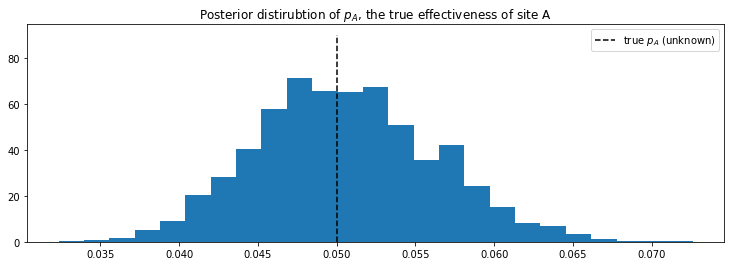

In [20]:
figsize(12.5, 4)
plt.title("Posterior distirubtion of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", density=True)
plt.legend();

Our posterior distribution put most weight near the true value $p_A$, but also some weights in the tails. 

#### *A* and *B* together

A similar analysis can be done for site B's response data to determine the analogous $p_B$.

But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, and $delta=p_A - p_B$, all at once.

In [21]:
import numpy as np

np.random.seed(100)

In [22]:
import pymc as pm
figsize(12, 4)

true_p_A = 0.05
true_p_B = 0.04

N_A = 1500
N_B = 1500

observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)

print("Obs from site A: ", observations_A[:30].astype(int), "...")
print("Obs from site B: ", observations_B[:30].astype(int), "...")

Obs from site A:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1] ...
Obs from site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0] ...


In [23]:
print(observations_A.mean())
print(observations_B.mean())

0.043333333333333335
0.044


In [24]:
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)


# Define the determinsitic delta function, This is our unknown of interest.

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# Set of observations, 

obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 sec

In [25]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

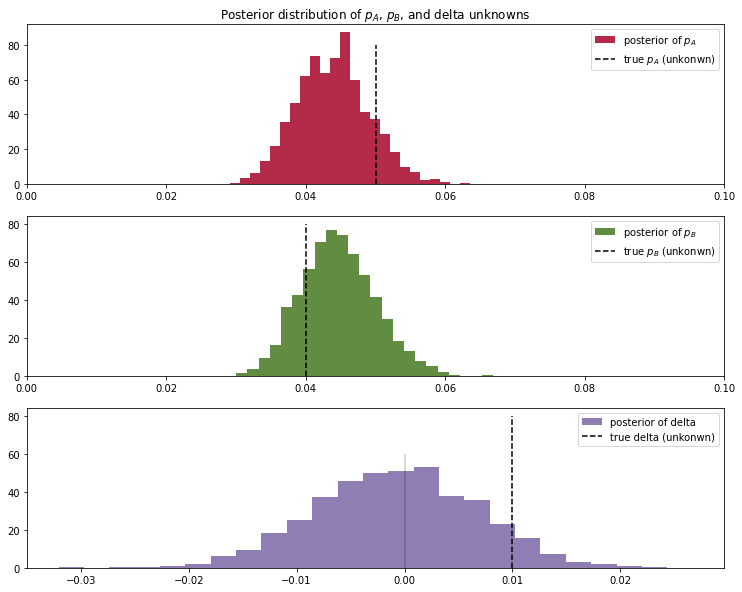

In [26]:
figsize(12.5, 10)

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype="stepfilled", bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unkonwn)")
plt.legend(loc="upper right")
plt.title("Posterior distribution of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype="stepfilled", bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unkonwn)")
plt.legend(loc="upper right")

ax = plt.subplot(313)

plt.hist(delta_samples, histtype="stepfilled", bins=25, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 80, linestyle="--", label="true delta (unkonwn)")
plt.vlines(0, 0, 60, color = "black", alpha=0.2)
plt.legend(loc="upper right")

In [27]:
print("Probability site A is WORSE than site B: %.3f" % \
      (delta_samples < 0).mean())
print("Probability site A is BETTER than site B: %.3f" % \
      (delta_samples > 0).mean())

Probability site A is WORSE than site B: 0.534
Probability site A is BETTER than site B: 0.466


### Binomial Distribution and human deceit

#### The binomial distriubtion

$$ P(X = k) = \binom{N}{k}p^{k}(1-p)^{N-k}$$

if $X$ is a binomial random variable with parameter $p$ and $N$, denote $ X \sim Bin(N, p)$, then, $X$ is the number of events that occured in the $N$ trials ($0 \le X \le N$), and $p$ is the probability of a single event.

Text(0.5, 1.0, 'Probability mass distributions of binomial random variables')

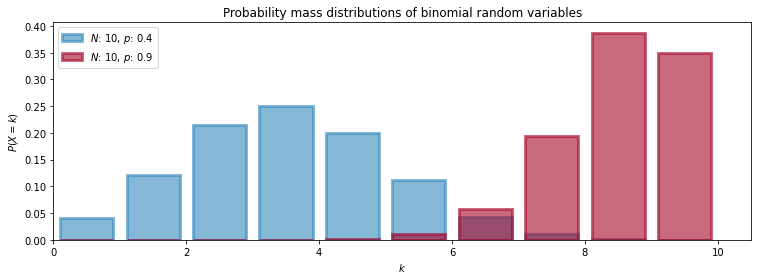

In [28]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N +1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor = colors[i],
           alpha=0.6,
           label="$N$: %d, $p$: %.1f"% (N, p),
           linewidth=3)
    
plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X=k)$")
plt.title("Probability mass distributions of binomial random variables")

The special case when $N = 1$ corresponds to Bernoullli distribution

#### Example: Cheating among students

$N$ be the total number of students who took the exam

$X$ is the number of answer "Yes I did cheat".

We need to find the posterior distribution of $p$, given $N$, some specified prior on $p$, and observed data $X$.

But obviously, this approach is contaminated by the social desirablity.

Privacy Algorithm: If coin comes up heads, students answer honestly; if the coin comes up tails, the student flips the coin again, and answer "yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat" if the coin flip lands tails

In [29]:
import pymc as pm

N = 100
p = pm.Uniform("freq_cheating", 0, 1)

In [30]:
true_answers = pm.Bernoulli("truths", p, size=N)

In [31]:
first_coin_flips = pm.Bernoulli("first_flips", 0.5, size=N)
print(first_coin_flips.value)

[False False  True  True False False False  True False  True  True  True
  True  True False  True False False False False  True False False  True
  True False  True  True False False False  True False  True  True  True
 False  True False  True False  True  True False False  True False False
 False  True False False False False False False  True  True  True  True
  True  True False False False  True False False False  True  True  True
  True False False False False  True  True False False False  True False
  True False  True  True  True False False  True  True False False  True
  True False  True False]


In [32]:
second_coin_flips = pm.Bernoulli("second_flips", 0.5, size=N)
print(second_coin_flips.value)

[ True  True  True False False  True False  True  True False  True  True
 False False  True  True  True False False  True False False  True  True
  True False  True  True  True  True False  True False  True  True  True
  True False  True False  True  True  True False False  True  True False
 False  True  True  True False False False False False  True  True  True
 False  True False False False False False False  True  True False  True
  True False  True  True False  True  True  True  True False  True False
  True False  True  True  True False False False False  True False False
 False  True False  True]


In [33]:
@pm.deterministic
def observed_proportion(t_a=true_answers,
                        fc=first_coin_flips,
                        sc=second_coin_flips):
    observed=fc*t_a + (1-fc)*sc
    return observed.sum() /float(N)

In [34]:
observed_proportion.value

0.36

In [35]:
X = 25 # exercise: what happens if we observed 25 affirmative repsonses, 10? 50?

observations = pm.Binomial('obs', N, observed_proportion, observed=True,
                            value=X)

In [36]:
model = pm.Model([p, true_answers, first_coin_flips, second_coin_flips,
                  observed_proportion, observations])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 7.4 sec

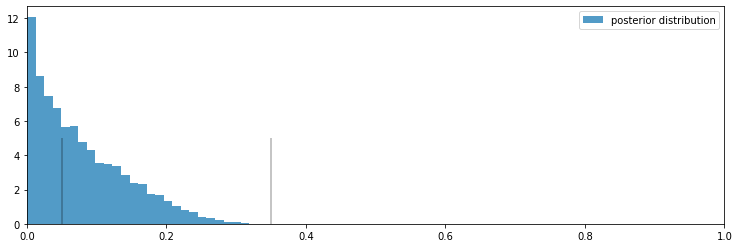

In [37]:
figsize(12.5, 4)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")

plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

#### Alternative PyMC Model

Given a value for $p$ (which from our god-like position we know), we can find the probability the student will answer yes:

$$ P("Yes") = P(Heads on first coin)P(cheater) + P(Tails on first coi)P(Heads on second coin) \\ = \frac {1} {2} p + \frac {1}{4}$$

Thus, knowing $p$ we know the probability a student will reponse "Yes". In PyMC, we can create a deterministic function to evaluate the prob of responding "Yes", given $p$:

In [38]:
p = pm.Uniform("freq_cheating", 0, 1)

@pm.deterministic
def p_skewed(p=p):
    return 0.5*p + 0.25

In [39]:
yes_responses = pm.Binomial("number_cheaters", 100, p_skewed,
                            value=50, observed=True)

# exercise: what happens if we observed 25 affirmative repsonses, 10? 50?

In [40]:
model = pm.Model([yes_responses, p_skewed, p])

mcmc = pm.MCMC(model)
mcmc.sample(25000, 2500)

/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 25000 of 25000 complete in 1.0 sec

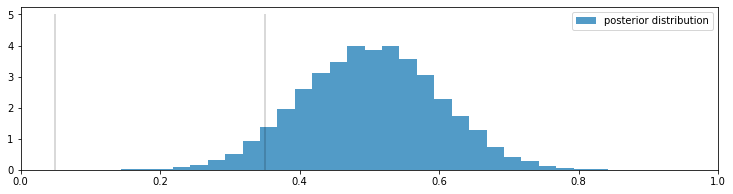

In [41]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

### More PyMC Tricks

#### Protip: lighter deterministic variables with `Lambda` class

Built-in `lamdab` functions can handle this with the elegance and simplicity required

In [42]:
import pymc as pm
import numpy as np
N = 1000
beta = pm.Normal("coefficients", 0, 1, size=(N,1))
x = np.random.randn(N, 1)
linear_combination = pm.Lambda("linear_combination", lambda x=x, beta=beta: np.dot(x.T, beta))
type(linear_combination)

pymc.CommonDeterministics.Lambda

#### Example: Challenger space shuttle disaster

On Jan 28, 1986, the twenty-fifth flight of the U.S space shuttle program ended in disaster when one of the rocket booster of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. ... Of previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. the data are shown below

Temp (F), O-Ring failure
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


Text(0.5, 1.0, 'Defects of the SpaceShuttle O-Rings vs temperature')

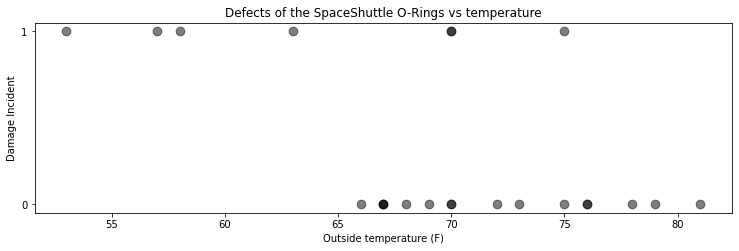

In [43]:
figsize(12.5, 3.5)

np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("pymc_data/challenger_data.csv", skip_header=1,
                                usecols=[1,2], missing_values="NA", 
                                delimiter=",")

# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:,1])]

# plot it, as a function of temperature

print("Temp (F), O-Ring failure")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color='k',
           alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident")
plt.xlabel("Outside temperature (F)")
plt.title("Defects of the SpaceShuttle O-Rings vs temperature")

It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here.

We need a function of tmeperature, call it $p(t)$, that bounded between 0 and 1 and changes from 1 to 0 as we increase temperature. The most popular choice is the *logistic function*.
$$p(t) = \frac{1}{1 + e ^{\beta t}}$$

In this model, $\beta$ is the variable we are uncertain about. Below are the function plotted for $\beta = 1, 3, -5$.

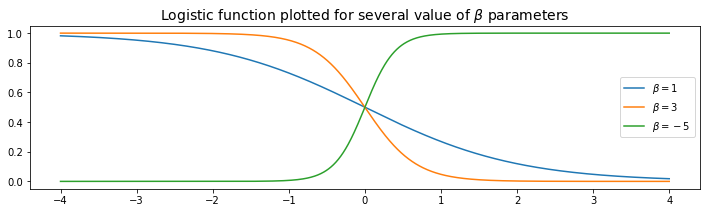

In [44]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0/(1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 1000)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.title("Logistic function plotted for several value of $\\beta$ parameters", fontsize=14)
plt.legend();

But something is missing, In the plot of the logistic function, the prob changes only near zero, but in our data above the prob changes around 65 to 70. We need to add a *bias* term to our logistic function:

$$p(t) = \frac{1}{1 + e^{\beta t + \alpha}}$$

Some plots are below, with varying $\alpha$

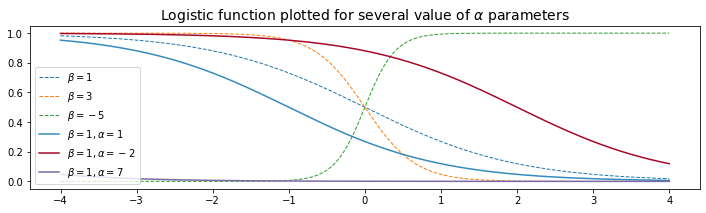

In [45]:
def logistic(x, beta, alpha=0):
    return 1.0/(1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 1000)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$", color="#348ABD")
plt.plot(x, logistic(x, 1, -2), label=r"$\beta = 1, \alpha = -2$", color="#A60628")
plt.plot(x, logistic(x, 1, 7), label=r"$\beta = 1, \alpha = 7$", color="#7A68A6")

plt.title("Logistic function plotted for several value of $\\alpha$ parameters", fontsize=14)
plt.legend(loc="lower left");

Let's sart model this in PyMC, the $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best model by a *Normal random variable*.

#### Normal distributions

A normal random variable, denoted $X \sim N(\mu, 1/\tau)$, has a distribution with two parameters: the mean, $\mu$, and the precision, $\tau$. Those familiar iwth the Normal distirubtion already have probably seen $\sigma^2$ instead of $\tau^{-1}$. They are in face reciprocals of each other. The change was motivated by simpler mathematical analysis and is an artifact of older Bayesian mehtods. 

The prob density fun of a $N(\mu, 1/\tau$) random variable is:

$$f(x|\mu, \tau) = \sqrt {\frac{\tau}{2\pi}}  exp \left(-\frac{\tau}{2}(x - \mu)^2 \right)$$

We plot some different density func below.

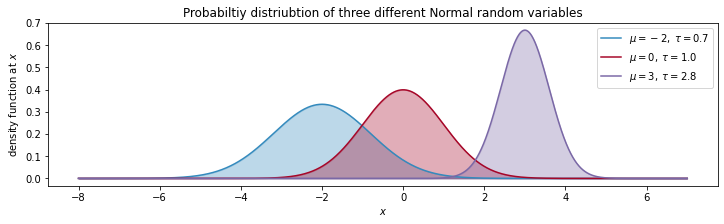

In [46]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 1500)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)

colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./np.sqrt(_tau)),
             label="$\mu = %d, \;\\tau = %.1f$" % (_mu, _tau), color = _color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./np.sqrt(_tau)), color=_color, 
                     alpha = .33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probabiltiy distriubtion of three different Normal random \
variables");

Below we continue our modelling of the Challenger space craft:

In [47]:
import pymc as pm

temperature = challenger_data[:,0]
D = challenger_data[:, 1]

beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

We use *Bernoulli* random variable with parameter $p$, denoted $Ber(p)$, to model the damage. Thus, our model looks like:

$$Defect Incident, D_{i} \sim Ber(p(t_i)), i = 1, 2, ...N $$

Where $p(t)$ is our logistic function and $t_i$ are the temperatures we have observed. 

Notice in the above code we have set the value of `beta` and `alpha` to 0. The reason for this is that if $\beta$ and $\alpha$ are very large, the make $p$ equal to 1 or 0. Unfortunately, `pm.Bernoulli` does not like prab of exactly 0 or 1. So by setting the coefficient values to `0` and `1`, we set the $p$ to be a reasonable starting value. This is simply a computational caveat in PyMC.

In [48]:
p.value

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [49]:
# connect the probability in `p` with our observations through a 
# Bernoulli random variable

observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

model=pm.Model([observed, beta, alpha])

# Mysterious code to be explained in Chater 3

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(12000, 10000, 2)

/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 12000 of 12000 complete in 0.8 sec

We have trained our model on the observed data, now we can sample values from th posterior. Let's look at the posterior distribution for $\alpha$ and $\beta$:

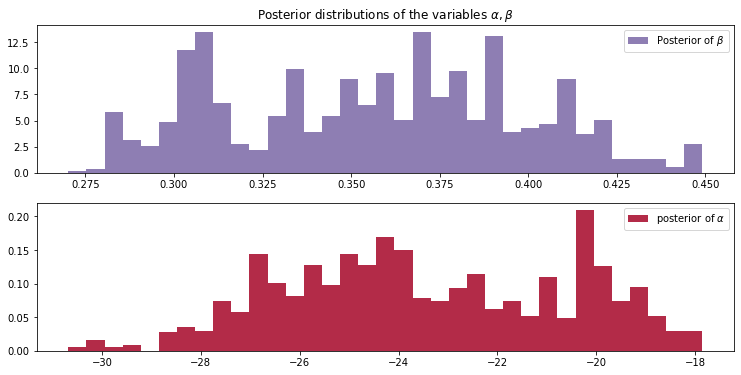

In [50]:
alpha_samples = mcmc.trace('alpha')[:, None]
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histgram of the sample:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"Posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype="stepfilled", bins=35, alpha=.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

All samples of $\beta$ are greater than 0;

All samples of $\alpha$ are negative and far away from 0.

Next, let's look at the expected probability for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for $p(t_i)$.

In [51]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

Text(0.5, 0, 'temperature')

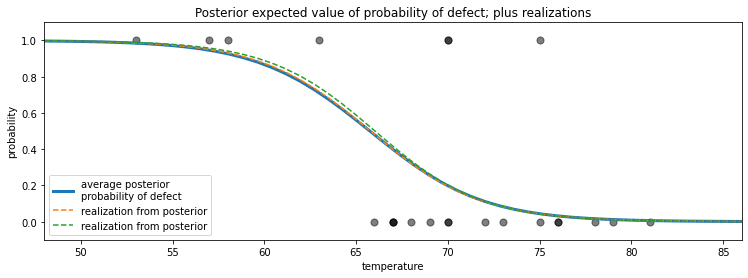

In [52]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2,:], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color='k', s=50, alpha=.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature")

Above we plotted two possible realization of what the actual underlying system might be. The blue line is what occures when we average all the 20000 possible dotted lines together.

Below we plot the expected vlaue line and the associated 95% intervals for each temperature.

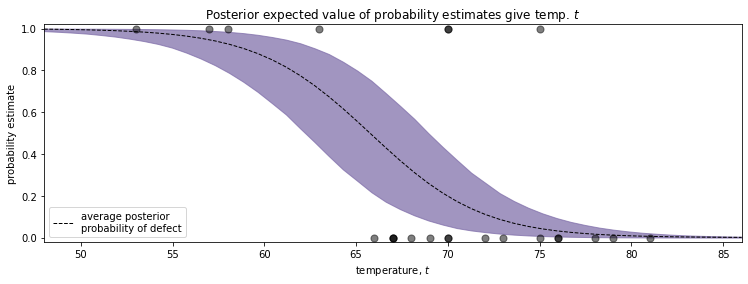

In [53]:
from scipy.stats.mstats import mquantiles

# vectorized botton and top 2.5% quantile for "credential intervals"

qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:,0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t, mean_prob_t, lw=1, ls = "--", color = "k", 
         label="average posterior \nprobability of defect")
plt.scatter(temperature, D, color='k', s=50, alpha=.5)

plt.legend(loc="lower left")
plt.ylim(-0.02, 1.02)
plt.xlim(t.min(), t.max())

plt.ylabel("probability estimate")
plt.xlabel("temperature, $t$")
plt.title("Posterior expected value of probability estimates give temp. $t$");

As we can see that as the temperature near 60 degrees, the CIs spread out over [0, 1]. As we pass 70 degrees, the CIs tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60 - 65 temperature to get a better estimate of prob.

#### What about the day of the challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distriubtion of a defect occurring, given this temperature? The distriubtion is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

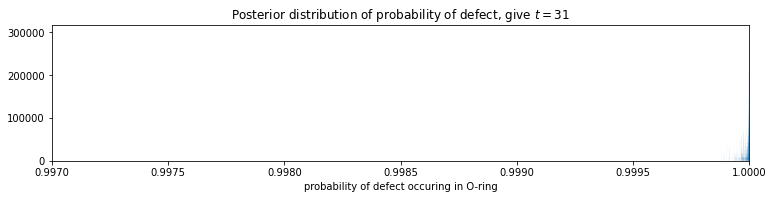

In [54]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.99
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         , 1)
plt.hist(prob_31, bins=1000, density=True, histtype="stepfilled")
plt.title("Posterior distribution of probability of defect, give $t=31$")
plt.xlabel("probability of defect occuring in O-ring");

#### Is our model appropriate?

"How do I know I have chosen a good model?" To consider an extreme situation, what if I have chosen the function $p(t) = 1, \forall t$, which guarantees a defect always occuring: I would have again predicted disaster on Jan 28th. yet this is clearly a poorly chosen model. This question encourage us to measure the model's **goodness of fit**.

An idea is to compare observed data (which if we recall is a *fixed* stochastic variable) with an artifical dataset which we can simulate. 

In the current example, we should sample from the posterior distrubtions to create *very plausible datasets*. Our Bayesian framework makes this very easy. We only needs to create a new `Stochastic` variable that is exactly the same as our variable that stored the observation, but mius the observations themselves. If your recall, our `Stochastic` variable that stored our observed data was:

```
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)
```

Here we create:

```
simulated_data = pm.Bernoulli("simulation_data", p)
```

Let's simulate 10 000:

In [55]:
simulated = pm.Bernoulli("bernoulli_sim", p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.1 sec

(10000, 23)


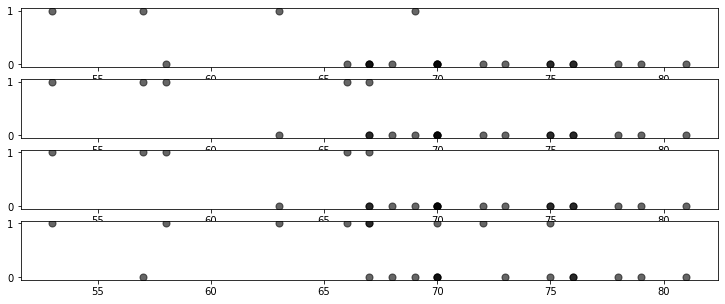

In [56]:
figsize(12.5, 5)

simulations = mcmc.trace("bernoulli_sim")[:]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000 * i, :], color="k",
                s=50, alpha=0.6)

Note that the above four plots are different.

"Good" is a subjective term. An alternative is to use *Bayesian p-values*, which is still subjective as the proper cutoff between good and bad is arbitrary.

The following graphical test is a novel data-viz approach to logsitc regression. The plots are called *separation plots*. For a suite of models we wish to compare, each model is plotted on an individual separation plot. 

For each model, we calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e., comput $P(Defect=1|t, \alpha, \beta)$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset. 

In [57]:
posterior_probability = simulations.mean(axis=0)
print("Posterior prob of defect | realized defect")
for i in range(len(D)):
    print("%.2f                     | %d" % (posterior_probability[i], D[i]))

Posterior prob of defect | realized defect
0.43                     | 0
0.24                     | 1
0.29                     | 0
0.33                     | 0
0.38                     | 0
0.17                     | 0
0.14                     | 0
0.25                     | 0
0.81                     | 1
0.58                     | 1
0.25                     | 1
0.06                     | 0
0.38                     | 0
0.89                     | 1
0.38                     | 0
0.10                     | 0
0.24                     | 0
0.04                     | 0
0.09                     | 0
0.05                     | 0
0.10                     | 1
0.09                     | 0
0.79                     | 1


Next, we sort each column by the posterior probabilities:

In [58]:
ix = np.argsort(posterior_probability)
print("probb | defect")
for i in range(len(D)):
    print("%.2f  | %d" % (posterior_probability[ix[i]], D[ix[i]]))

probb | defect
0.04  | 0
0.05  | 0
0.06  | 0
0.09  | 0
0.09  | 0
0.10  | 1
0.10  | 0
0.14  | 0
0.17  | 0
0.24  | 0
0.24  | 1
0.25  | 0
0.25  | 1
0.29  | 0
0.33  | 0
0.38  | 0
0.38  | 0
0.38  | 0
0.43  | 0
0.58  | 1
0.79  | 1
0.81  | 1
0.89  | 1


We can present the above data better in a figure, which was wrapper by XX in a `separation_pot` function.

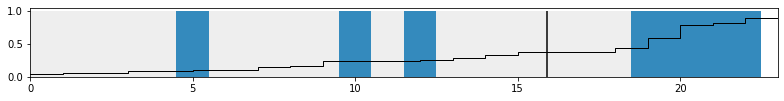

In [59]:
from separation_plot import separation_plot

figsize(11., 1.5)

separation_plot(posterior_probability, D)

It's much more informative to compare this to separation plots for other models. Below we compare our model (top) versus three others:

1. The perfect model, which predicts the posterior probability to be equal to 1 if a defect did  occur;
2. A completely random model, which predicts random probabilites regardless of temperature;
3. A constant model: where $P(D = 1 | t) = c, \forall t$. Thebest choce for $c$ is the observed frequency of defects, in this case 7/23.

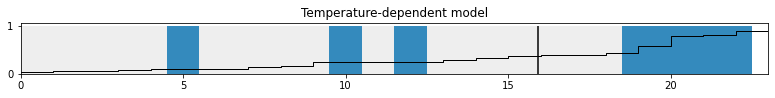

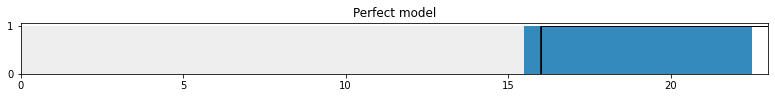

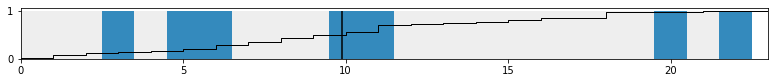

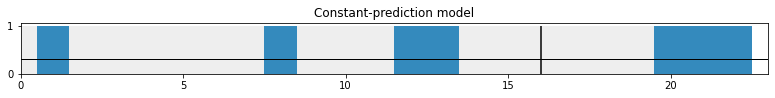

In [60]:
figsize(11., 1.25)

# our model
separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

# Perfect model
# i.e., the prob of defect is equal to if a defect occured or not.

p = D
separation_plot(p, D)
plt.title("Perfect model")

# random model
p = np.random.rand(23)
separation_plot(p, D)

# constant model
constant_prob = 7./23 * np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");

In the random model, we can see that the prob increase there is no clustering of defects to the right-hand side.

### Summarizing this chapter:

What I learnt from this chapter is this
1. Better understanding of PyMC variables. One particularly interesting point about PyMC `stochastic variable` is that both parameter and data are represented by this type of variable, and that observation (data) can only be represented by this.
2. Observations, because they are stochastic variables, included the distribution/likelihood.
3. pm.Model include observation (a stochastic variable), parameters (stochastic variables). Because observations already included the likelihood function, pm.MCMC can sample the posterior of the parameters.
4. The name of the stochastic variables are used for retrieval their traces, if those stochastic variables are in the model in the first place.
5. You need to use mathematic formulas to epxress your hypothesis/parameters, as revealed by the "Chanllenger Space Shuttle" example.
6. `separation_plots` is a very nice plot for plotting the PPC of logistic distribution.